In [32]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

### Store CSV into DataFrame

In [5]:
file1 = "Resources/PPPLoans.csv"
loans_df = pd.read_csv(file1)
loans_df.head(1)

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
0,a $5-10 million,"ARCTIC SLOPE NATIVE ASSOCIATION, LTD.",7000 Uula St,BARROW,AK,99723.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,295.0,4/14/2020,"National Cooperative Bank, National Association",AK - 00


### Create new data with select columns

In [7]:
loans_new=loans_df[["State","JobsRetained"]]
loans_new.rename(columns={"State":"state","JobsRetained":"jobsretained"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [8]:
loans_new.head(1)

,state,jobsretained
0,AK,295.0


In [9]:
loans_state=loans_new.groupby("state").sum()
loans_state.head(1)

,jobsretained
state,
AK,67587.0


In [10]:
loans_state.reset_index(inplace=True)
loans_state.head(1)

,state,jobsretained
0,AK,67587.0


In [11]:
file2 = "Resources/June Unemployment Rate.csv"
unemp_rate_df = pd.read_csv(file2)
unemp_rate_df.head(1)

,State,June 2020 unemployment rate,June 2019 unemployment rate,12-month percentage point change
0,Massachusetts,17.4,2.9,14.5


In [12]:
june_rate_df = unemp_rate_df[["State","June 2020 unemployment rate"]]
june_rate_df.rename(columns={"State":"state_name","June 2020 unemployment rate":"unemp_rate"},inplace = True)

In [13]:
june_rate_df["state_name"]=june_rate_df["state_name"].str.upper()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
june_rate_df.head(1)

,state_name,unemp_rate
0,MASSACHUSETTS,17.4


In [15]:
file3="Resources/state_name.csv"
state_name=pd.read_csv(file3)
state_name.rename(columns={"Abbreviation":"state","State":"state_name"},inplace=True)
state_name=state_name[["state","state_name"]]
state_name.head(1)

,state,state_name
0,AL,ALABAMA


### Connect to local database

In [16]:
rds_connection_string = "postgres:6325460@localhost:5432/ppp_loans"
engine = create_engine(f'postgresql://{rds_connection_string}')

### Check for tables

In [17]:
engine.table_names()

['ppp_loan', 'unemployment_rate', 'state_name']

### Use pandas to load csv converted DataFrame into database

In [18]:
loans_state.to_sql(name='ppp_loan', con=engine, if_exists='replace', index=False)
june_rate_df.to_sql(name='unemployment_rate',con=engine, if_exists='replace', index=False)
state_name.to_sql(name='state_name', con=engine, if_exists='replace', index=False)

### Confirm data has been added by querying the customer_name table

In [19]:
pd.read_sql_query('select * from ppp_loan', con=engine).head()

,state,jobsretained
0,AK,67587.0
1,AL,408803.0
2,AR,209212.0
3,AS,1565.0
4,AZ,616020.0


In [20]:
pd.read_sql_query('select * from state_name', con=engine).head()

,state,state_name
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [28]:
pd.read_sql_query('select * from unemployment_rate', con=engine).head()

,state_name,unemp_rate
0,MASSACHUSETTS,17.4
1,NEW JERSEY,16.6
2,NEW YORK,15.7
3,NEVADA,15.0
4,CALIFORNIA,14.9


In [43]:
data_df=pd.read_sql_query('select * from loan_unemp_state', con=engine)

In [44]:
data_df.head()

,state,jobsretained,unemp_rate
0,MA,740747.0,17.4
1,NJ,925095.0,16.6
2,NY,2044978.0,15.7
3,NV,305664.0,15.0
4,CA,4140900.0,14.9


In [45]:
data_df.set_index("state", inplace=True)

In [46]:
data_df.head()

,jobsretained,unemp_rate
state,,
MA,740747.0,17.4
NJ,925095.0,16.6
NY,2044978.0,15.7
NV,305664.0,15.0
CA,4140900.0,14.9


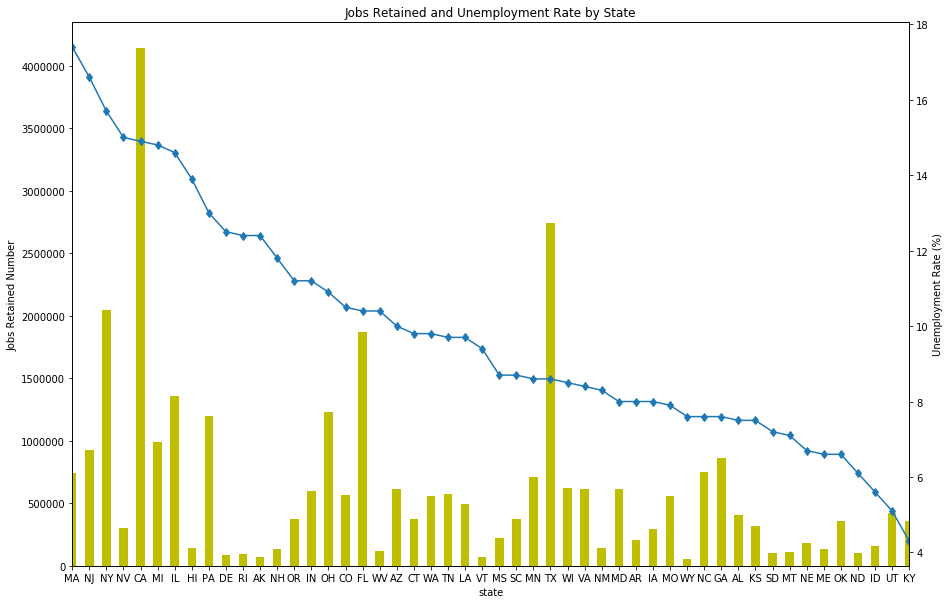

In [62]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1 =data_df['jobsretained'].plot(kind='bar', color='y' )
ax2 = data_df['unemp_rate'].plot(kind='line', marker='d', secondary_y=True)
plt.title("Jobs Retained and Unemployment Rate by State")

ax1.set_ylabel('Jobs Retained Number')
ax2.set_ylabel('Unemployment Rate (%)')
plt.savefig("chart.png")
plt.show()